## Simulación Tasa de Pobreza
Marzo 15, 2022 <br>
Laura Goyeneche

### Library

In [12]:
import numpy as np
import pandas as pd
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
%%capture
%matplotlib inline
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Working directory

In [13]:
## Working directory
scldatalake = "s3://cf-p-scldata-prod-s3-p-scldata-app"

# Harmonized data
harmonized  = "Household Socio-Economic Surveys/Harmonized Household Surveys"

# Poverty lines 
povertyline = "Data Projects/International Poverty Lines/international_poverty_lines.csv"
pl          = pd.read_csv(f'{scldatalake}/{povertyline}')

### Data Preparation

#### Harmonized HH Surveys

In [5]:
%%capture

# Calculate HH income
hh = []
for year in range(2010,2021)[::-1]:      
    # Import data
    data = pd.read_csv(f'{scldatalake}/{harmonized}/concat/csv/harmonized-{year}.csv')
    
    # HH income 
    ytot_ci_vars    = ['ylm_ci','ylnm_ci','ynlm_ci','ynlnm_ci']
    data['ytot_ci'] = data.loc[data.miembros_ci == 1, ytot_ci_vars].sum(axis = 1)
    data['ytot_ch'] = data.loc[data.miembros_ci == 1,].groupby(['idh_ch','pais_c']).ytot_ci.transform(sum)
    data.loc[data.ytot_ch < 0,'ytot_ch'] = np.nan
    data['pc_ytot_ch'] = data.ytot_ch / data.nmiembros_ch
    data               = data[['pais_c','anio_c','mes_c','factor_ch','idh_ch','ytot_ch','pc_ytot_ch']]
    
    # Append to master list
    hh.append(data)

In [6]:
# Create dataframe
hh = pd.concat(hh)

# Keep most recent data 
hh['recent_'] = hh.groupby('pais_c').anio_c.transform(max)
hh = hh[hh.anio_c == hh.recent_]
hh = hh.drop(columns = 'recent_')

In [7]:
# Countries included
print('Number of countries: ',hh.pais_c.unique().shape[0])
print(hh.pais_c.unique().tolist())

Number of countries:  19
['ARG', 'BOL', 'BRA', 'COL', 'CRI', 'DOM', 'ECU', 'PER', 'PRY', 'SLV', 'URY', 'VEN', 'GTM', 'GUY', 'HND', 'PAN', 'BRB', 'BHS', 'JAM']


#### Poverty lines

In [88]:
# Reshape long to wide 
index = ['year','isoalpha3']
pl = pl.pivot(index = index, columns = 'indicator', values = 'value')
pl = pl.reset_index()
pl = pl.drop(columns = ['ppp_wdi2011','tc_wdi'])
pl = pl.rename(columns = {'isoalpha3':'code'})

# CPI 2011 = 100
pl['cpi_2011' ] = [pl[(pl.code == x) & (pl.year == 2011)].cpi.item() for x in pl.code]

# Keep most recent year
pl = pl[pl.year == 2020]

# Rename variables for merge 
pl.rename(columns = {'code':'pais_c'}, inplace = True)

### International Poverty Lines Function

In [111]:
# Poverty lines calculation
def int_lp(hh, data, w, c):
    # Create copy
    data_ = data.copy()
    hh_   = hh.copy()
    
    # Changes in CPI
    data_['cpi_hat'] = data_.cpi * w * (1 + c) + data_.cpi * (1 - w)
    
    # CPI 2011 = 100
    data_['cpi_ratio'] = data_.cpi_hat / data_.cpi_2011
    
    # Poverty lines 
    # Changes in CPI 
    data_['lp19_2011'] = (1.9*(365/12)) * data_.cpi_ratio * data_.ppp_2011
    data_['lp31_2011'] = (3.1*(365/12)) * data_.cpi_ratio * data_.ppp_2011
    data_['lp05_2011'] = (5.0*(365/12)) * data_.cpi_ratio * data_.ppp_2011
    
    # Changes in PL 
    data_['lp19_2011_'] = ((1.9*(365/12)) * (data_.cpi / data_.cpi_2011) * data_.ppp_2011) * (1 + c)
    data_['lp31_2011_'] = ((3.1*(365/12)) * (data_.cpi / data_.cpi_2011) * data_.ppp_2011) * (1 + c)
    data_['lp05_2011_'] = ((5.0*(365/12)) * (data_.cpi / data_.cpi_2011) * data_.ppp_2011) * (1 + c)
    
    # Identify poverty lines vars
    lp_vars = [name for name in data_.columns if 'lp' in name]
    
    # Adjust for changes in Venezuelan currency
    for name in lp_vars:
        data_.loc[data_.pais_c == 'VEN',name] = data_.loc[data_.pais_c == 'VEN',name] / 100000000
    
    # Merge with HH 
    tasas = hh_.merge(data_, on = 'pais_c', how = 'left')
    
    # Replace Nas in factor_ch
    tasas.factor_ch = tasas.factor_ch.fillna(1)
    
    # Calculate poor indicator
    # Changes in CPI
    tasas['poor19'] = (tasas.pc_ytot_ch < tasas.lp19_2011).astype(int) * tasas.factor_ch
    tasas['poor31'] = (tasas.pc_ytot_ch < tasas.lp31_2011).astype(int) * tasas.factor_ch
    tasas['poor05'] = (tasas.pc_ytot_ch < tasas.lp05_2011).astype(int) * tasas.factor_ch
    
    # Changes in LP
    tasas['poor19_'] = (tasas.pc_ytot_ch < tasas.lp19_2011_).astype(int) * tasas.factor_ch
    tasas['poor31_'] = (tasas.pc_ytot_ch < tasas.lp31_2011_).astype(int) * tasas.factor_ch
    tasas['poor05_'] = (tasas.pc_ytot_ch < tasas.lp05_2011_).astype(int) * tasas.factor_ch
    
    # Identify poverty rates vars
    poor_vars = [name for name in tasas.columns if 'poor' in name]
    
    # Replace NA values
    for name in poor_vars:
        tasas[name].fillna(0, inplace = True)
    
    # Results
    tasas = tasas.groupby(['pais_c','anio_c'])[poor_vars + ['factor_ch']].sum()
    tasas = tasas.reset_index()
    
    # Calculate % poor
    for name in poor_vars:
        tasas[name] = (tasas[name] / tasas.factor_ch) * 100 

    # Add variables
    tasas['weight'] = w*100
    tasas['change'] = c*100
    
    return tasas

### Simulation

In [112]:
# Run multiple scenarios
weight = [i/100 for i in range(0,30,10)]
change = [i/100 for i in range(0,32,2) ]
final  = []
for i in weight:
    for j in change:
        final.append(int_lp(hh,pl,i,j))

# Master table
final = pd.concat(final)

In [113]:
# Calculate changes in poverty 
for i in ['poor19','poor31','poor05']:
    final[f'{i}_baseline'] = [final[(final.pais_c == x) & (final.weight == 0) & (final.change == 0)][i].item() for x in final.pais_c]
    final[f'{i}_pp']       = final[i] - final[f'{i}_baseline']
    final[f'{i}_pp_']      = final[f'{i}_'] - final[f'{i}_baseline']

In [115]:
print(final.weight.unique())
print(final.change.unique())

[ 0. 10. 20.]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]


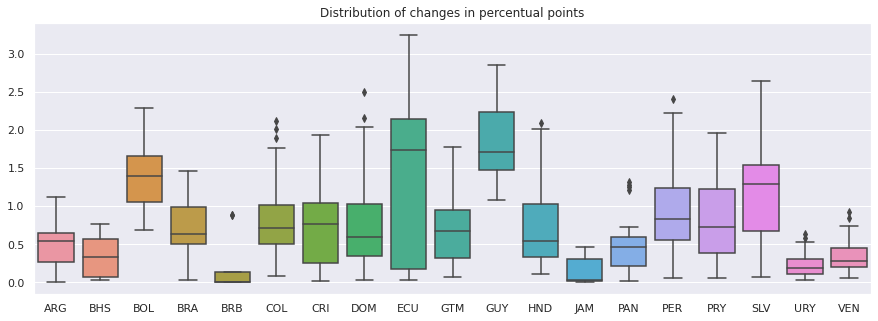

In [116]:
# Distribution in changes in poverty
plt.figure(figsize = (15,5))
var = "poor05_pp"
ax = sns.boxplot(x = 'pais_c', y = var, data = final[(final.weight > 0) & (final.change > 0)])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of changes in percentual points')
plt.show()

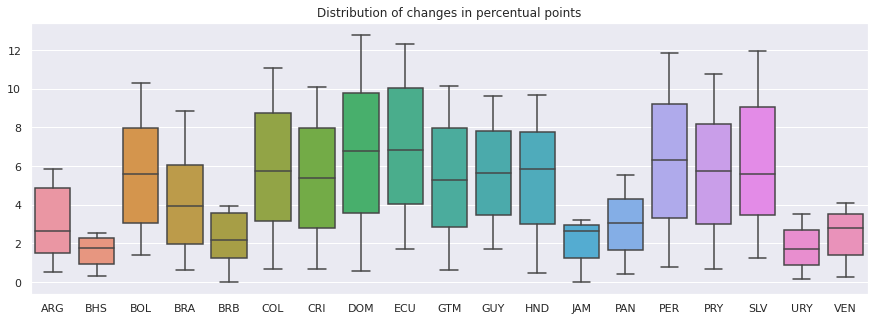

In [118]:
# Distribution in changes in poverty
plt.figure(figsize = (15,5))
var = "poor05_pp_"
ax = sns.boxplot(x = 'pais_c', y = var, data = final[(final.weight == 0) & (final.change > 0)])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of changes in percentual points')
plt.show()

In [24]:
# Ejemplo para Colombia
# Data
temp = final.copy()
temp = temp.rename(columns = {'poor19':'Income < $1.9pc/day','poor31':'Income < $3.1pc/day','poor05':'Income < $5.0pc/day'})
temp = temp[temp.pais_c == "COL"]
temp.weight = temp.weight.astype(int)
temp.change = temp.change.astype(int)

# Poverty level
colnames = [i for i in temp.columns if 'Income' in i]

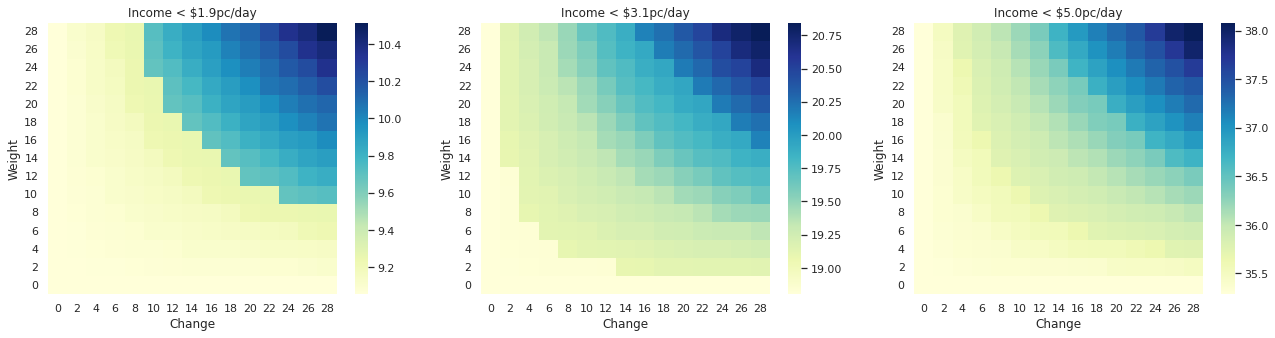

In [23]:
# Figure by poverty level 
plt.figure(figsize = (22,5))

for i,name in enumerate(colnames):
    # Filter dataset
    temp_ = pd.pivot_table(temp, values = name, index = 'weight', columns = 'change')
    
    # Subplot
    plt.subplot(1,3,i+1)
    ax = sns.heatmap(temp_, cmap = "YlGnBu")
    
    # Names and labels
    plt.title(name)
    ax.invert_yaxis()
    plt.yticks(rotation = 0)
    plt.ylabel('Weight')
    plt.xlabel('Change')
    
plt.show()